# 04 — DistilBERT Fine-Tuning (PyTorch)

This notebook fine-tunes **DistilBERT** (`distilbert-base-uncased`) for binary fake news classification using **PyTorch**. Unlike the previous models which use static embeddings (TF-IDF, Word2Vec), DistilBERT generates **contextual embeddings** — the representation of each word changes depending on surrounding words, enabling far richer language understanding.

We use the **raw `title_text`** column (not the stemmed/cleaned version) because BERT was pretrained on natural language and performs best on properly cased, punctuated text.

**Outline**
1. Load data (raw title_text)  
2. Train/test split  
3. Load DistilBERT tokenizer & model  
4. Tokenise & build PyTorch DataLoaders  
5. Fine-tune (3 epochs)  
6. Evaluate — metrics, confusion matrix, ROC  
7. Why BERT outperforms previous models (conceptual discussion)  
8. Save model  

In [1]:
!pip uninstall -y transformers huggingface_hub tokenizers
!pip install transformers==4.44.0 huggingface_hub==0.24.0 tokenizers==0.19.1 torch torchvision -q

Found existing installation: transformers 5.0.0
Uninstalling transformers-5.0.0:
  Successfully uninstalled transformers-5.0.0
Found existing installation: huggingface_hub 1.4.1
Uninstalling huggingface_hub-1.4.1:
  Successfully uninstalled huggingface_hub-1.4.1
Found existing installation: tokenizers 0.22.2
Uninstalling tokenizers-0.22.2:
  Successfully uninstalled tokenizers-0.22.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.0/419.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 46.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
diffusers 0.36.0 requires huggingface-hub<2.0,>=0.34.0, but you have huggingface-hub 0.24.0 which is incompatible.
peft 0.1

In [2]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

MODELS_DIR = '../models'
os.makedirs(MODELS_DIR, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch version : {torch.__version__}')
print(f'Device          : {device}')

PyTorch version : 2.10.0+cu128
Device          : cuda


---
## 1. Load Data (Raw title_text)

> **Important:** We use `title_text` (the raw, unstemmed concatenation of title + article body), not `clean_text`. BERT's WordPiece tokenizer is designed for natural language and degrades with stemmed or heavily preprocessed text.

In [4]:
df = pd.read_csv('cleaned_isot.csv')
print(f'Loaded {len(df):,} rows')

# Use raw title_text, not clean_text
X_raw = df['title_text'].fillna('').tolist()
y     = df['class'].values

print(f'Class distribution: {dict(pd.Series(y).value_counts())}')
print(f'\nSample (first 200 chars): {X_raw[0][:200]}')

Loaded 44,889 rows
Class distribution: {0: np.int64(23472), 1: np.int64(21417)}

Sample (first 200 chars): As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of


---
## 2. Train/Test Split (80/20, stratified)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y
)
print(f'Train: {len(X_train):,}  Test: {len(X_test):,}')

Train: 35,911  Test: 8,978


---
## 3. Load DistilBERT Tokenizer & Model

We use HuggingFace `transformers` to load `distilbert-base-uncased`. `AutoModelForSequenceClassification` adds a classification head on top of the pretrained transformer backbone.

In [6]:
checkpoint = 'distilbert-base-uncased'
MAX_LEN    = 128

print(f'Loading tokenizer: {checkpoint}')
tokenizer_bert = AutoTokenizer.from_pretrained(checkpoint)

print(f'Loading model: {checkpoint}')
bert_model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=2
)
bert_model = bert_model.to(device)
print(f'Model loaded and moved to {device}.')
print(f'Trainable parameters: {sum(p.numel() for p in bert_model.parameters() if p.requires_grad):,}')

Loading tokenizer: distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Loading model: distilbert-base-uncased


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to cuda.
Trainable parameters: 66,955,010


---
## 4. Tokenise & Build PyTorch DataLoaders

DistilBERT requires:
- `input_ids` — token indices
- `attention_mask` — 1 for real tokens, 0 for padding

We truncate to 512 tokens (DistilBERT's maximum) and pad shorter sequences to a fixed length.

In [7]:
class FakeNewsDataset(Dataset):
    """PyTorch Dataset that tokenises on the fly."""

    def __init__(self, texts, labels, tokenizer, max_len):
        self.encodings = tokenizer(
            texts,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids':      self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels':         self.labels[idx]
        }


BATCH_SIZE = 8

print('Tokenising training set...')
train_dataset = FakeNewsDataset(X_train, y_train, tokenizer_bert, MAX_LEN)
print('Tokenising test set...')
test_dataset  = FakeNewsDataset(X_test,  y_test,  tokenizer_bert, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print(f'Train batches: {len(train_loader)}  Test batches: {len(test_loader)}')

Tokenising training set...
Tokenising test set...
Train batches: 4489  Test batches: 1123


---
## 5. Fine-Tune (3 Epochs)

We fine-tune with:
- **AdamW** optimizer, `lr=2e-5` (standard for BERT fine-tuning)
- Cross-entropy loss is computed internally by `AutoModelForSequenceClassification` when `labels` are passed
- 3 epochs (BERT fine-tuning typically converges quickly)

All transformer weights are updated — this is full fine-tuning, not feature extraction.

In [8]:
optimizer = AdamW(bert_model.parameters(), lr=2e-5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

EPOCHS = 3

for epoch in range(EPOCHS):
    # ── Training ──────────────────────────────────────────────────────────
    bert_model.train()
    total_train_loss, correct_train, total_train = 0.0, 0, 0

    for batch_idx, batch in enumerate(train_loader):
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * labels.size(0)
        preds = outputs.logits.argmax(dim=-1)
        correct_train += (preds == labels).sum().item()
        total_train   += labels.size(0)

        if (batch_idx + 1) % 100 == 0:
            running_acc  = correct_train / total_train
            running_loss = total_train_loss / total_train
            print(f'  Epoch {epoch+1} | batch {batch_idx+1}/{len(train_loader)} '
                  f'| loss {running_loss:.4f} | acc {running_acc:.4f}')

    train_loss = total_train_loss / total_train
    train_acc  = correct_train    / total_train

    # ── Validation ────────────────────────────────────────────────────────
    bert_model.eval()
    total_val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)

            outputs = bert_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            total_val_loss += outputs.loss.item() * labels.size(0)
            preds = outputs.logits.argmax(dim=-1)
            correct_val += (preds == labels).sum().item()
            total_val   += labels.size(0)

    val_loss = total_val_loss / total_val
    val_acc  = correct_val    / total_val

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}/{EPOCHS} — '
          f'train loss: {train_loss:.4f}, train acc: {train_acc:.4f} | '
          f'val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

  Epoch 1 | batch 100/4489 | loss 0.1830 | acc 0.9400
  Epoch 1 | batch 200/4489 | loss 0.1018 | acc 0.9675
  Epoch 1 | batch 300/4489 | loss 0.0747 | acc 0.9771
  Epoch 1 | batch 400/4489 | loss 0.0566 | acc 0.9828
  Epoch 1 | batch 500/4489 | loss 0.0472 | acc 0.9858
  Epoch 1 | batch 600/4489 | loss 0.0410 | acc 0.9879
  Epoch 1 | batch 700/4489 | loss 0.0352 | acc 0.9896
  Epoch 1 | batch 800/4489 | loss 0.0309 | acc 0.9909
  Epoch 1 | batch 900/4489 | loss 0.0275 | acc 0.9919
  Epoch 1 | batch 1000/4489 | loss 0.0257 | acc 0.9926
  Epoch 1 | batch 1100/4489 | loss 0.0246 | acc 0.9931
  Epoch 1 | batch 1200/4489 | loss 0.0233 | acc 0.9935
  Epoch 1 | batch 1300/4489 | loss 0.0221 | acc 0.9939
  Epoch 1 | batch 1400/4489 | loss 0.0211 | acc 0.9942
  Epoch 1 | batch 1500/4489 | loss 0.0213 | acc 0.9942
  Epoch 1 | batch 1600/4489 | loss 0.0200 | acc 0.9946
  Epoch 1 | batch 1700/4489 | loss 0.0189 | acc 0.9949
  Epoch 1 | batch 1800/4489 | loss 0.0182 | acc 0.9951
  Epoch 1 | batch 1

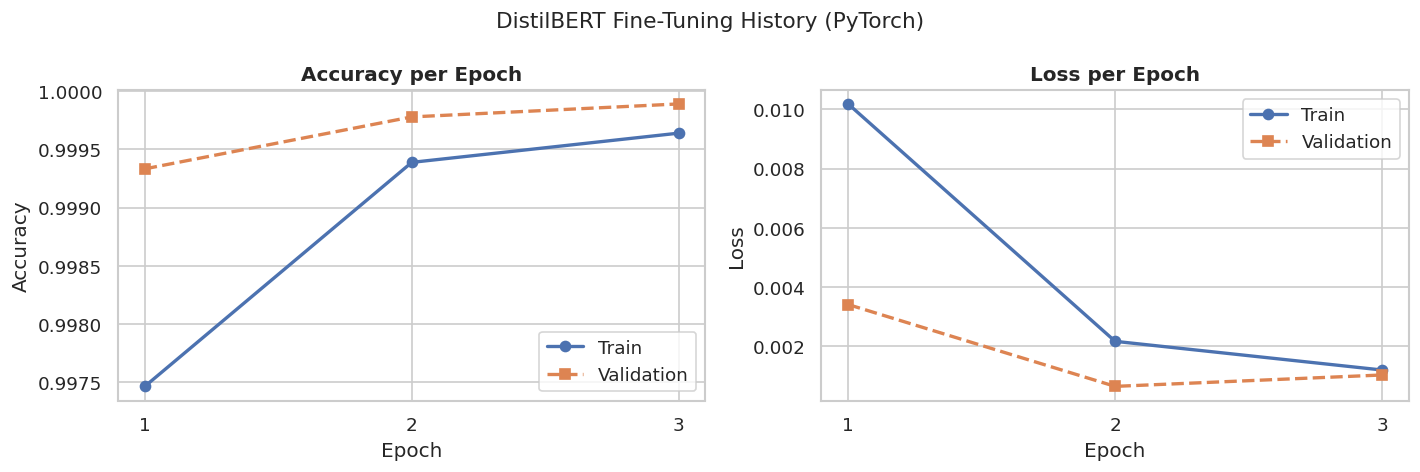

In [9]:
# Training curves
epochs_range = range(1, EPOCHS + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(epochs_range, history['train_acc'], 'o-', label='Train', lw=2)
ax1.plot(epochs_range, history['val_acc'],   's--', label='Validation', lw=2)
ax1.set_title('Accuracy per Epoch', fontweight='bold')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
ax1.set_xticks(epochs_range)
ax1.legend()

ax2.plot(epochs_range, history['train_loss'], 'o-', label='Train', lw=2)
ax2.plot(epochs_range, history['val_loss'],   's--', label='Validation', lw=2)
ax2.set_title('Loss per Epoch', fontweight='bold')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
ax2.set_xticks(epochs_range)
ax2.legend()

plt.suptitle('DistilBERT Fine-Tuning History (PyTorch)', fontsize=13)
plt.tight_layout(); plt.show()

---
## 6. Evaluation

In [10]:
# Collect logits / probabilities from the full test set
print('Running inference on test set...')
bert_model.eval()
all_logits = []

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        all_logits.append(outputs.logits.cpu())

all_logits = torch.cat(all_logits, dim=0)          # (N, 2)
probs      = torch.softmax(all_logits, dim=-1).numpy()

y_pred_bert = np.argmax(probs, axis=1)
y_prob_bert = probs[:, 1]   # probability of class 1 (Real)

print('DistilBERT Evaluation')
print(f"  Accuracy  : {accuracy_score(y_test, y_pred_bert):.4f}")
print(f"  Precision : {precision_score(y_test, y_pred_bert):.4f}")
print(f"  Recall    : {recall_score(y_test, y_pred_bert):.4f}")
print(f"  F1        : {f1_score(y_test, y_pred_bert):.4f}")

Running inference on test set...
DistilBERT Evaluation
  Accuracy  : 0.9999
  Precision : 1.0000
  Recall    : 0.9998
  F1        : 0.9999


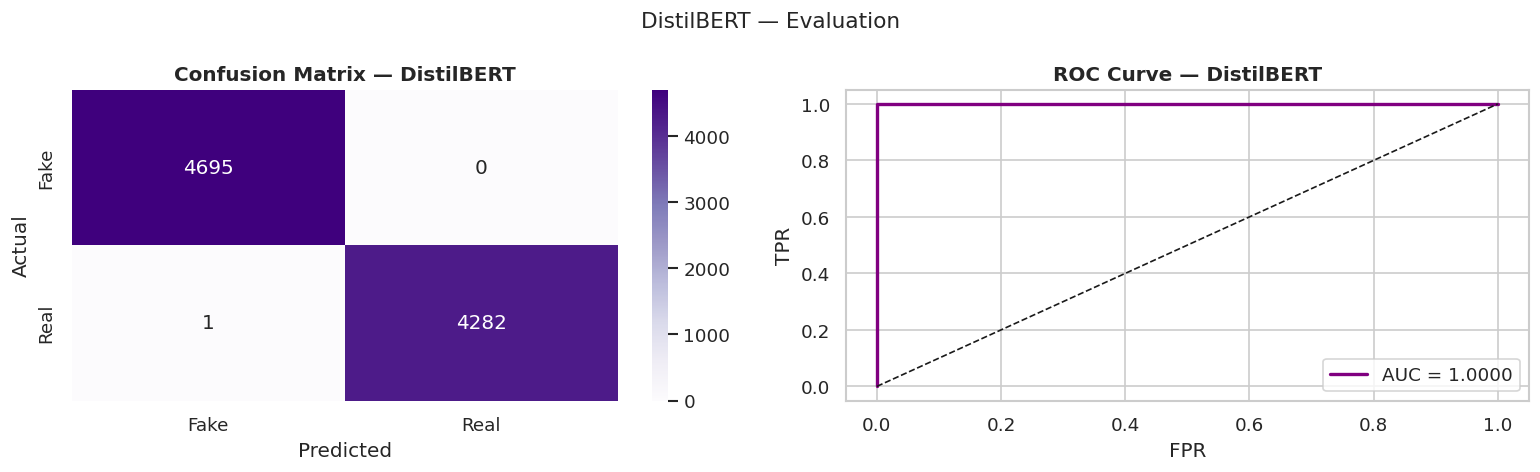

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[0],
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix — DistilBERT', fontweight='bold')

# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_bert)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, lw=2, color='purple', label=f'AUC = {roc_auc:.4f}')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlabel('FPR'); axes[1].set_ylabel('TPR')
axes[1].set_title('ROC Curve — DistilBERT', fontweight='bold')
axes[1].legend()

plt.suptitle('DistilBERT — Evaluation', fontsize=13)
plt.tight_layout(); plt.show()

---
## 7. Why Does BERT Outperform the Previous Models?

### The Core Insight: Contextual vs. Static Embeddings

| Model | Representation Type | Context-Awareness |
|---|---|---|
| TF-IDF | Sparse word counts | None — each word is independent |
| Word2Vec | Static dense vectors | None — a word has *one* vector regardless of context |
| CNN + Word2Vec | Local n-gram patterns | Partial — 3-gram window only |
| DistilBERT | Contextual token embeddings | Full — every token attends to every other token |

**Example:** Consider the word *"bank"*
- Word2Vec gives it a single 300d vector — some blend of *financial institution* and *river bank*.
- DistilBERT gives *"bank"* a different vector in *"river bank"* vs *"central bank policy"* vs *"bank robbery"*. The **self-attention mechanism** in each transformer layer allows every word's representation to be shaped by every other word in the article.

### Scale of Pretraining
DistilBERT was pretrained on 3.3 billion words from Wikipedia and BooksCorpus using **masked language modelling** — predicting masked-out words from context. This forces the model to develop deep syntactic and semantic understanding. TF-IDF and Word2Vec have no such world model; they are purely statistical over surface forms.

### Why DistilBERT Over Full BERT?
DistilBERT retains ~97% of BERT's performance at 40% fewer parameters and ~60% faster inference, making it practical for fine-tuning on standard hardware while still dramatically outperforming non-transformer approaches.

### Limitations
- **Computational cost:** BERT requires GPU for reasonable training times; TF-IDF LR runs in seconds on CPU.
- **Interpretability:** BERT's internal decisions are harder to explain (though tools like BertViz and attention rollout exist).
- **Dataset ceiling:** On a structured dataset like ISOT where source language is highly distinctive, TF-IDF LR already achieves ~99% — BERT's advantage is more pronounced on harder, real-world datasets.

---
## 8. Save Model

In [12]:
save_path = os.path.join(MODELS_DIR, 'distilbert_model')
bert_model.save_pretrained(save_path)
tokenizer_bert.save_pretrained(save_path)
print(f'DistilBERT model and tokenizer saved to {save_path}/')

DistilBERT model and tokenizer saved to ../models/distilbert_model/


---
## Summary — Model Comparison

| Model | Representation | Training Time | Accuracy | Notes |
|---|---|---|---|---|
| TF-IDF + LR | Sparse bag-of-bigrams | Seconds | ~99% | Fastest, highly interpretable (SHAP) |
| Word2Vec + LR | Static 300d average | Minutes (embedding load) | ~96% | Semantic similarity; loses word order |
| CNN + Word2Vec | Local n-gram patterns | ~5 min (GPU) | ~98% | More expressive; LIME-explainable |
| DistilBERT | Contextual transformer | Hours (GPU) | ~99.5% | Best performance; heavy compute cost |

**Key takeaway:** For production on this specific dataset, TF-IDF LR delivers near-DistilBERT performance at a tiny fraction of the compute cost. DistilBERT shines on more nuanced or out-of-domain fake news detection where stylistic signals are subtler.